<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/VARMA_TEMPERATURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [143]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/temperature.csv


File ‘temperature.csv’ already there; not retrieving.



In [144]:
!head temperature.csv

"record_id","month","day","year","AverageTemperatureFahr","AverageTemperatureUncertaintyFahr","City","country_id","Country","Latitude","Longitude"
474376,"01","01","1853",NA,NA,"Auckland","NEW","New Zealand","36.17S","175.03E"
474377,"02","01","1853",NA,NA,"Auckland","NEW","New Zealand","36.17S","175.03E"
474378,"03","01","1853",NA,NA,"Auckland","NEW","New Zealand","36.17S","175.03E"
474379,"04","01","1853",NA,NA,"Auckland","NEW","New Zealand","36.17S","175.03E"
474380,"05","01","1853",NA,NA,"Auckland","NEW","New Zealand","36.17S","175.03E"
474381,"06","01","1853",51.9062,36.9572,"Auckland","NEW","New Zealand","36.17S","175.03E"
474382,"07","01","1853",52.3886,34.5488,"Auckland","NEW","New Zealand","36.17S","175.03E"
474383,"08","01","1853",52.853,33.5498,"Auckland","NEW","New Zealand","36.17S","175.03E"
474384,"09","01","1853",52.5776,33.638,"Auckland","NEW","New Zealand","36.17S","175.03E"


In [145]:
df = pd.read_csv("temperature.csv")

In [146]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [147]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s,'%Y-%m-%d')

In [148]:
df['Date'] = df.apply(parse_date,axis = 1)

In [149]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [150]:
#Keep only columns we want
auckland = auckland[['Date','AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date','AverageTemperatureFahr']].copy()

In [151]:
#set index to date col
auckland.set_index(auckland['Date'],inplace = True)

In [152]:
auckland.head()

,Date,AverageTemperatureFahr
Date,,
1853-06-01,1853-06-01,51.9062
1853-07-01,1853-07-01,52.3886
1853-08-01,1853-08-01,52.8530
1853-09-01,1853-09-01,52.5776
1853-10-01,1853-10-01,54.8726


In [153]:
auckland.drop('Date',axis = 1,inplace = True)
auckland.columns = ['AucklandTemp']

In [154]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [155]:
stockholm.set_index(stockholm['Date'],inplace = True)
stockholm.drop('Date',axis = 1,inplace = True)
stockholm.rename(columns = {'AverageTemperatureFahr':'StockholmTemp'},inplace = True)

In [156]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [157]:
#Join the data
#Has some missing data
joined = auckland.join(stockholm,how = 'outer')

In [158]:
joined.shape

(3155, 2)

In [159]:
joined.tail()

,AucklandTemp,StockholmTemp
Date,,
2013-04-01,64.1102,36.8096
2013-05-01,59.5004,51.3428
2013-06-01,56.2100,57.7544
2013-07-01,54.2210,62.6360
2013-08-01,56.7644,62.4632


In [160]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [161]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [162]:
joined_part.isnull().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [163]:
joined_part.interpolate(inplace = True)

In [164]:
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

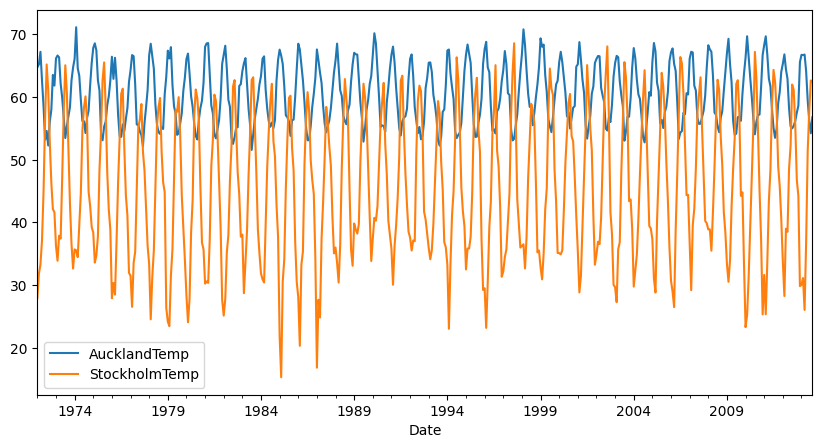

In [165]:
joined_part.plot(figsize = (10,5));

In [166]:
NTest = 12
train = joined_part.iloc[:-NTest].copy()
test  = joined_part.iloc[-NTest:].copy()

In [167]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
    train[['AucklandTemp']]
)
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [168]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(
    train[['StockholmTemp']]
)
test['ScaledStockholm'] = scaler_stockholm.transform(
    test[['StockholmTemp']]
)

In [169]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [170]:
joined_part.loc[train_idx,'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx,'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx,'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx,'ScaledStockholm'] = test['ScaledStockholm']

<Axes: xlabel='Date'>

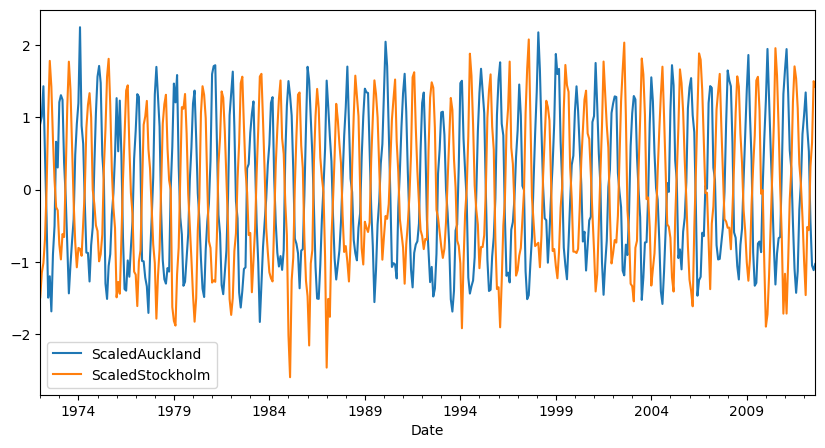

In [172]:
cols = ['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize = (10,5))

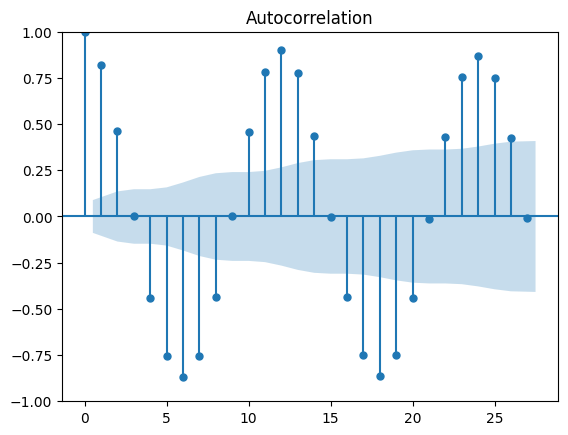

In [174]:
plot_acf(train['ScaledAuckland']);

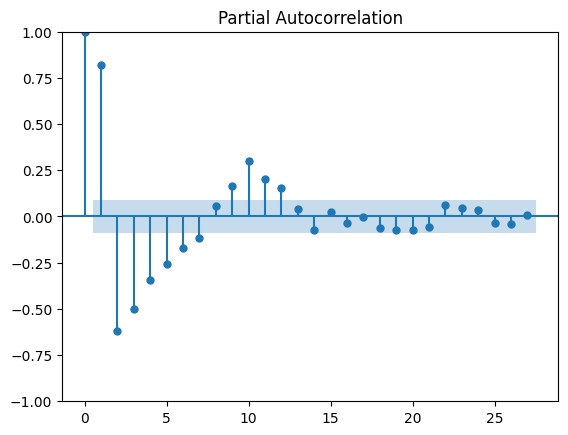

In [175]:
plot_pacf(train['ScaledAuckland']);